# Create Agents by LangGraph
**LangGraph** builds on **LangChain** to manage more workflows with branching paths, state processing, clear transitions between steps. **LangGraph** uses a graph-based structure for building stateful AI applications. 
<br>
In **LangGraph**,
* `nodes` represent individual tasks
* `edges` define the paths that connect nodes
* `state` is information that moves between nodes

## Key components of AI application built on LangChain
At the heart of every LangGraph AI application is a **state** object which defines a clear and strongly typed state for entire workflow. The **state** could be Python `TypedDict` or `LangGraph.State` object, ensuring that data passed between components is well-sstructured and type-checked.
<br>
Each **node** functions as a processing unit. They can handle tasks such as generating search queries, calling external API, transforming data, etc. These **nodes** are usually implemented as Python functions. 
<br>
The **edges** between nodes determine the directed flow of data, defining how information moves through the graph. **Condiftional edges** allows you to define dynamic execution paths based on the runtime state.

# Example of creating AI agent by LangGraph
In this example, we will build an AI application that can interact with Fake bank system.

### Fake Bank System

In [1]:
from pydantic import BaseModel

class Account(BaseModel):
    """Represents a bank account with a name and balance."""
    name: str
    balance: float


class UserAccountSystem(BaseModel):
    """Represents a collection of bank accounts for a user."""
    accounts: list[Account]

    def get_account_names(self) -> list[str]:
        """Returns a list of the names of all accounts."""
        return [acc.name for acc in self.accounts]

    def get_account(self, name:str) -> Account:
        """Returns the account with the given name.

        Raises:
            ValueError: If no account with the given name exists.
        """
        for acc in self.accounts:
            if acc.name==name:
                return acc
        raise ValueError(f"There is no account named {name}. Options are {', '.join(self.get_account_names())}")

    def transfer_money(self, amount: float, source_acc_name: str, dest_acc_name: str) -> None:
        """Transfers money from one account to another.

        Raises:
            ValueError: If the source account does not have enough funds.
        """
        source_account = self.get_account(source_acc_name)
        destination_account = self.get_account(dest_acc_name)
        
        if source_account.balance < amount:
            error_message = (
                f"There is not enough funds in account {source_acc_name}. "
                f"The balance is only ${source_account.balance}."
            )
            raise ValueError(error_message)
        
        source_account.balance = source_account.balance - amount
        destination_account.balance = destination_account.balance + amount

In [2]:
user_accounts = UserAccountSystem(
    accounts = [
        Account(name="checking-account", balance=100),
        Account(name="savings-account", balance=3000)
    ]
)

### Define tools for agent
We will employ the `tool` decorator to define tools for agent.

In [3]:
from langchain_core.tools import tool

In [4]:
@tool
def list_accounts() -> str:
    """List the names of the user's accounts."""
    return user_accounts.get_account_names()

@tool
def get_account_balance(account_name:str) -> str:
    """Get the balance of one of the user accounts by its exact name."""
    try:
        acc = user_accounts.get_account(account_name)
        return f"${acc.balance}"
    except ValueError as error:
        return f"{error}"

@tool
def transfer_money(amount:float, source_account:str, destination_account:str) -> str:
    """Transfer money between two accounts."""
    try:
        user_accounts.transfer_money(amount, source_account, destination_account)
        return "Successful transaction"
    except ValueError as error:
        return f"{error}"

In [5]:
tools = [
    list_accounts,
    get_account_balance,
    transfer_money
]

### Set up Prompt for instructing Agent to work

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate

In [8]:
prompt_template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(
        """
        You are an agent that helps the users manage their accounts in a Bank.
        Users may not refer to their account by the exact name, so try to get a list of valid names
        before getting a balance or executing a transaction.
        """
    ),
    MessagesPlaceholder(variable_name="messages", optional=True)
])

### building Agent
For using LangGraph to build AI Agent, we need to use Chat LLM.

In [9]:
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(
    model_name="gemini-2.0-flash-001",
    temperature=0.0
)

In [10]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=tools,
    prompt=prompt_template
)

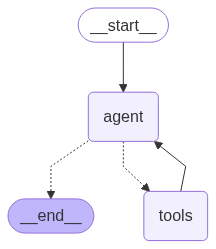

In [11]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

### Define state for Agent

In [12]:
initial_state = {
    "messages" :[
        ("human", "Hello, what can you help me with?")
    ]
}

In [13]:
from rich import print as pprint

In [14]:
state = agent.invoke(initial_state)

pprint(state)

{
    'messages': [
        HumanMessage(
            content='Hello, what can you help me with?',
            additional_kwargs={},
            response_metadata={},
            id='f8fd91bc-17ff-4212-afb7-484c4e1da5b0'
        ),
        AIMessage(
            content='I can help you with managing your bank accounts. I can list your accounts, get the balance of 
a specific account, or transfer money between two accounts. What would you like to do?\n',
            additional_kwargs={},
            response_metadata={
                'is_blocked': False,
                'safety_ratings': [],
                'usage_metadata': {
                    'prompt_token_count': 130,
                    'candidates_token_count': 39,
                    'total_token_count': 169,
                    'prompt_tokens_details': [{'modality': 1, 'token_count': 130}],
                    'candidates_tokens_details': [{'modality': 1, 'token_count': 39}],
                    'thoughts_token_count': 0,
                    'cached_content_token_count': 0,
                    'cache_tokens_details': []
                },
                'finish_reason': 'STOP',
                'avg_logprobs': -0.026565741270016402,
                'model_name': 'gemini-2.0-flash-001'
            },
            id='run--e686a04a-2ac4-4fc9-a62f-caa588b30096-0',
            usage_metadata={'input_tokens': 130, 'output_tokens': 39, 'total_tokens': 169}
        )
    ]
}

pretty print for the steps of Agent

In [15]:
for msg in state['messages']:
    msg.pretty_print()

================================ Human Message =================================

Hello, what can you help me with?
================================== Ai Message ==================================

I can help you with managing your bank accounts. I can list your accounts, get the balance of a specific account, or transfer money between two accounts. What would you like to do?


In [16]:
def pretty_print_state(state):
    for message in state['messages']:
        message.pretty_print()

### Prompt to agent that will trigger agent to call tools

In [19]:
initial_state = {
    "messages" :[
        ("human", "Whats the balance in my savings-account?")
    ]
}

state = agent.invoke(initial_state)

In [20]:
pretty_print_state(state)

================================ Human Message =================================

Whats the balance in my savings-account?
================================== Ai Message ==================================
Tool Calls:
  list_accounts (ebcbc504-d669-490d-8376-fec3fcb7248f)
 Call ID: ebcbc504-d669-490d-8376-fec3fcb7248f
  Args:
================================= Tool Message =================================
Name: list_accounts

["checking-account", "savings-account"]
================================== Ai Message ==================================
Tool Calls:
  get_account_balance (8de8c7c7-8890-41eb-8f4e-44645c122883)
 Call ID: 8de8c7c7-8890-41eb-8f4e-44645c122883
  Args:
    account_name: savings-account
================================= Tool Message =================================
Name: get_account_balance

$3000.0
================================== Ai Message ==================================

OK. The balance in your savings-account is $3000.0.


In [21]:
initial_state = {
    "messages" :[
        ("human", "Transfer $10 from checking-account to saving-account please")
    ]
}

state = agent.invoke(initial_state)

In [22]:
pretty_print_state(state)

================================ Human Message =================================

Transfer $10 from checking-account to saving-account please
================================== Ai Message ==================================
Tool Calls:
  transfer_money (00825634-0223-45c7-9154-aca107be4a71)
 Call ID: 00825634-0223-45c7-9154-aca107be4a71
  Args:
    destination_account: saving-account
    source_account: checking-account
    amount: 10.0
================================= Tool Message =================================
Name: transfer_money

There is no account named saving-account. Options are checking-account, savings-account
================================== Ai Message ==================================
Tool Calls:
  transfer_money (32919258-fbc8-40cb-80b1-69d2a8014a8d)
 Call ID: 32919258-fbc8-40cb-80b1-69d2a8014a8d
  Args:
    destination_account: savings-account
    source_account: checking-account
    amount: 10.0
================================= Tool Message =======================

In [23]:
print(get_account_balance("savings-account"))

$3010.0


C:\Users\andrewchan\AppData\Local\Temp\ipykernel_20644\1713787301.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(get_account_balance("savings-account"))


In [24]:
print(get_account_balance("checking-account"))

$90.0
